In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
import seaborn as sns
sns.set_style("whitegrid")

sys.path.append("../../pyelftools")             # relative location of pyelftools repo cloned from github
from elftools.elf.elffile import ELFFile
from tqdm import tqdm
from scipy import stats
from collections import Counter

In [2]:
path = "ppc64/"
files = os.listdir(path)
len(files)

5667

In [3]:
np.random.seed(1)
sample_files = np.random.choice(files, size=1000, replace=False)

In [4]:
def extract_code(path, file_list, min_file_size=10000, n_files=100):
    
    code_dict = {}
    counter = 0
    
    for file in file_list:
        with open(path + file, "rb") as f:
            try:
                elffile = ELFFile(f)
            except:
                continue
        
            try:
                text_section_header = elffile.get_section_by_name(".text").header
            except:
                continue
            offset = text_section_header.sh_offset
            size = text_section_header.sh_size
        
            if size >= min_file_size: # minimum size cutoff: 10kb of machine code
                counter += 1
                f.seek(offset)
                code_dict[file] = list(f.read(size))
                if counter == n_files: # number of files to select samples from
                    break
            else:
                continue
                
    return code_dict

In [5]:
sample_code_dict = extract_code(path, sample_files)
len(sample_code_dict.keys())

100

In [6]:
for file, code in sample_code_dict.items():
    print("%s\t%s\t%s" %(file, str(len(code)), code[:10]))

d5ba75a5276d2183c4ab771d36396711	55916	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
914e2af7227b7548338a2330ec74d4a7	15616	[248, 65, 0, 40, 233, 130, 131, 136, 125, 137]
6635866fdb56c3c220c71f51162a86e3	84572	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
44c070fff4aca602aa91bfef37cc84b6	1839820	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
d66461ae01598efee390059a88ad774a	73292	[248, 65, 0, 40, 233, 130, 133, 104, 125, 137]
f455191bae86aed7db6b4e97fd01ce4b	21696	[248, 65, 0, 40, 233, 130, 129, 216, 125, 137]
0944a79b0902b2d90ca4037cb982ad00	19124	[248, 65, 0, 40, 233, 130, 134, 88, 125, 137]
0349fee4e719a128fb6567882beb5bf9	332084	[248, 65, 0, 40, 233, 130, 138, 120, 125, 137]
c9832dc035359f5277019150bf07826e	20372	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
4404d471599b1771bee6abe99910d8df	160444	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
e18a1652808c8746b3891e7c0026d2f3	95996	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
a578b14bd2d080ba1e950aeeacd65a2c	20516	[248, 65, 0, 40, 233, 13

In [7]:
def plot_dists(dictionary):
    for file, code in dictionary.items():
        sns.distplot(code, 
                     bins = 256,
                     kde=False,
                     hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':0.1}, 
                     kde_kws={'cumulative': True},
                     norm_hist=True,
                     color="blue")
    plt.show()

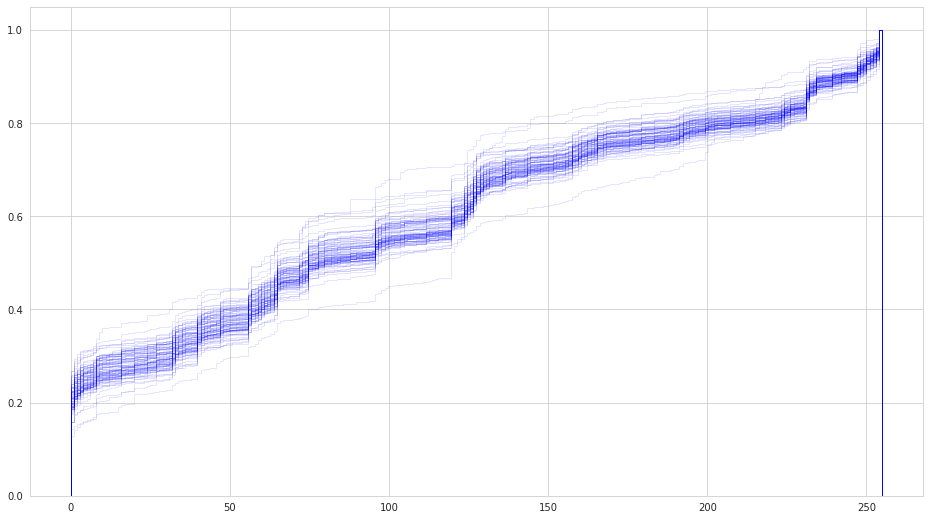

In [8]:
plot_dists(sample_code_dict)

In [9]:
def plot_sample(sample):
    sns.distplot(sample,
                 norm_hist=True,     
                 kde=False,
                 hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':0.1, 'alpha':0.1},
                 kde_kws={'cumulative': True},  # want CDF
                 bins=256,                      
                 color="blue")

def create_code_samples(sample_size, n_rows, sample_source, plot=False):
    
    samples_df = pd.DataFrame(index=np.arange(0, n_rows), columns=[i for i in range(sample_size)])
    
    for i in tqdm(np.arange(0, n_rows)):
        sample = np.random.choice(sample_source, size=sample_size, replace=True)
        samples_df.loc[i] = sorted(sample)
        
    samples_mean = samples_df.mean(axis = 0)
    
    if plot is True:
        sns.distplot(samples_mean, norm_hist=True, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},kde_kws={'cumulative': True},bins=256,color="red")
        plt.show()    
    
    return samples_mean

In [10]:
def create_reference_distribution(code_dictionary, sample_size, n_samples):
    # create data frame to hold mean sample of each file's code
    means_df = pd.DataFrame(index=list(code_dictionary.keys()),
                            columns=[i for i in range(sample_size)])
    
    # for each file's code, store mean of the samples in data frame
    for file, code in code_dictionary.items():
        means_df.loc[file] = create_code_samples(sample_size,
                                                 n_samples,
                                                 code)
    # average all samples means together
    mean = means_df.mean(axis = 0)
    median = means_df.median(axis = 0)
    return mean, median

In [11]:
mean, median = create_reference_distribution(sample_code_dict, 1000, 1000)

100%|██████████| 1000/1000 [00:46<00:00, 21.50it/s]


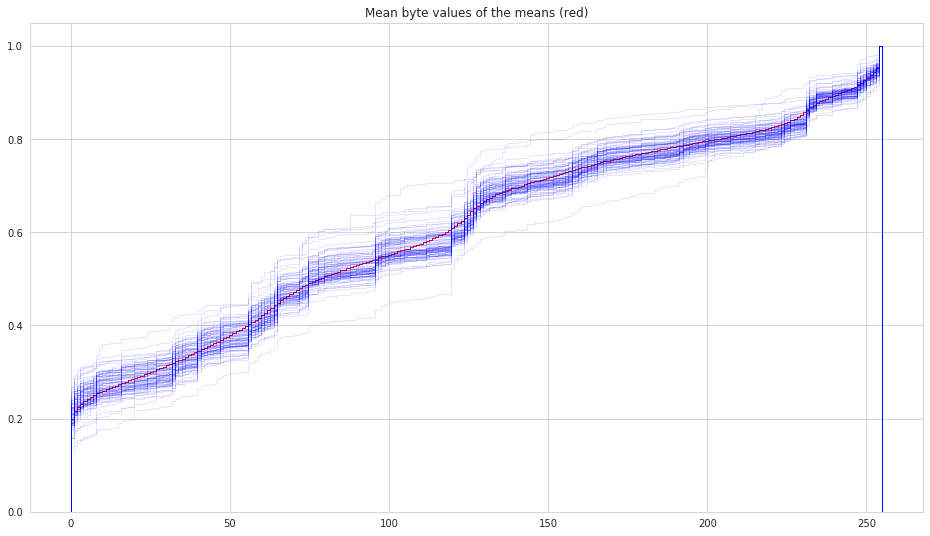

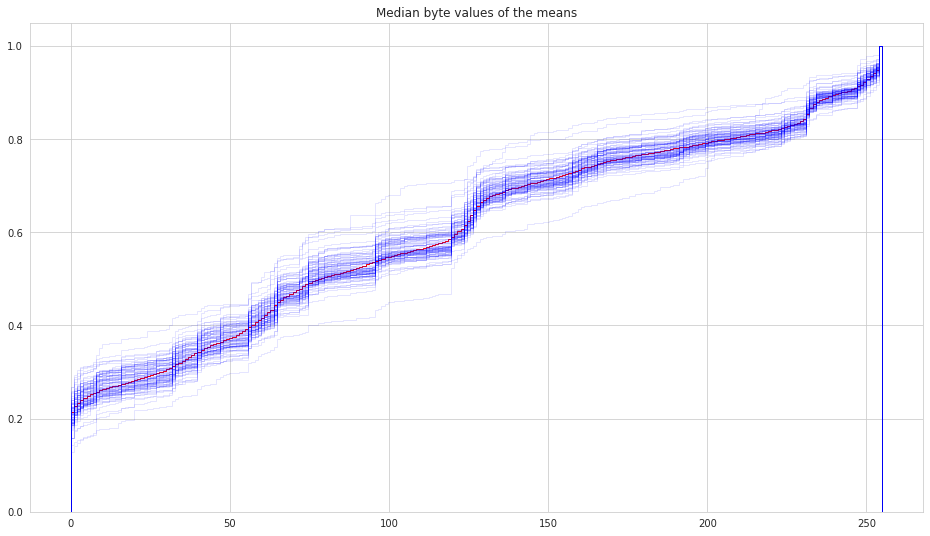

In [12]:
sns.distplot(mean, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Mean byte values of the means (red)")
plot_dists(sample_code_dict)


sns.distplot(median, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Median byte values of the means")
plot_dists(sample_code_dict)

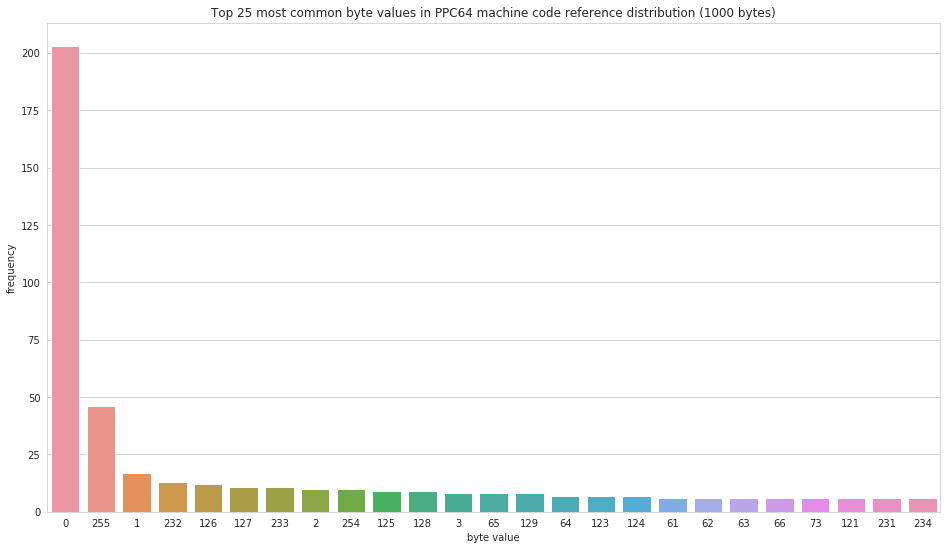

In [13]:
rounded_medians = [round(i) for i in median]
sorted_counts = sorted(Counter(rounded_medians).items(), key = lambda x: x[1], reverse=True)

counts_df = pd.DataFrame(sorted_counts[:25])
counts_df = counts_df.rename(columns={0:"byte value", 1:"frequency"})

sns.barplot(x="byte value", y="frequency", data=counts_df, order=counts_df["byte value"])
plt.title("Top 25 most common byte values in PPC64 machine code reference distribution (1000 bytes)")
plt.show()

In [14]:
[hex(i) for i in list(dict(sorted_counts).keys())[:25]]

['0x0',
 '0xff',
 '0x1',
 '0xe8',
 '0x7e',
 '0x7f',
 '0xe9',
 '0x2',
 '0xfe',
 '0x7d',
 '0x80',
 '0x3',
 '0x41',
 '0x81',
 '0x40',
 '0x7b',
 '0x7c',
 '0x3d',
 '0x3e',
 '0x3f',
 '0x42',
 '0x49',
 '0x79',
 '0xe7',
 '0xea']

In [15]:
# get pool of test files
test_pool = [file for file in files if file not in sample_files]

# select test files
np.random.seed(1)
test_files = np.random.choice(test_pool, size=3000, replace=False)

In [16]:
len(test_files)

3000

In [17]:
# check for overlap between files that the reference distribution was built from and the files used for testing
list(set(sample_code_dict.keys()) & set(test_files))

[]

In [18]:
test_code_dict = extract_code(path, test_files, n_files=3000)

for file, code in test_code_dict.items():
    print("%s\t%s\t%s" % (file, str(len(code)), code[:10]))

058299ff5c9a25aaaacd9c56997adaa5	56240	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
48cb498139a56eee20b0074874692e1f	19896	[248, 65, 0, 40, 233, 130, 132, 88, 125, 137]
8be40b3f8e8d771106f23144d00d5fbc	139256	[248, 65, 0, 40, 233, 130, 140, 112, 125, 137]
4a29cb350c5e3e510500c9d39cd40ed1	216996	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
125b6ce77a3e2231885b2df56b8f826f	2196152	[232, 126, 0, 16, 124, 35, 8, 64, 65, 128]
79e4a6fb774a31740fa99157494dc15e	91876	[248, 65, 0, 40, 233, 130, 144, 72, 125, 137]
17698762b69a49bb59ac29f173c1f5ca	30212	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
9a0f527c590d7129355652436590b7c9	414780	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
02e54fc2af06506b54a221fe400bbe9e	11884	[248, 65, 0, 40, 233, 130, 129, 120, 125, 137]
c91bb41bbbaf205d7bc00003d1185571	109556	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
e6538b37fbdb026802f787cb6c74e1c8	32268	[248, 65, 0, 40, 61, 98, 255, 255, 233, 139]
bb998bfdf5104c7177f74293a0f07d24	230360	[248, 65, 0, 40, 61, 98, 2

In [19]:
len(test_code_dict.keys())

1070

In [20]:
test_results_df = pd.DataFrame(index=test_code_dict.keys(),
                               columns=["size", "wasserstein distance","energy distance", "mean", "median", "standard deviation"])

for file, code in test_code_dict.items():
    test_results_df.loc[file]["size"] = len(code)
    test_results_df.loc[file]["wasserstein distance"] = stats.wasserstein_distance(median, code)
    test_results_df.loc[file]["energy distance"] = stats.energy_distance(median, code)
    test_results_df.loc[file]["mean"] = np.mean(code)
    test_results_df.loc[file]["median"] = np.median(code)
    test_results_df.loc[file]["standard deviation"] = np.std(code)
    
print(test_results_df.shape)
test_results_df

(1070, 6)


,size,wasserstein distance,energy distance,mean,median,standard deviation
058299ff5c9a25aaaacd9c56997adaa5,56240,17.0128,1.60332,83.4297,64,79.7823
48cb498139a56eee20b0074874692e1f,19896,1.9301,0.212243,102.109,83,89.9481
8be40b3f8e8d771106f23144d00d5fbc,139256,2.69854,0.306754,98.4452,75,89.8357
4a29cb350c5e3e510500c9d39cd40ed1,216996,1.78752,0.195123,99.7932,75,89.3622
125b6ce77a3e2231885b2df56b8f826f,2196152,2.01376,0.245219,100.122,78,88.0158
...,...,...,...,...,...,...
f5b54ae5e8f9e54d2713c72048497a35,103172,3.55474,0.373033,97.22,75,87.0558
dc65747e6fdd3b258b02b0dbe199bbe1,20180,2.02907,0.225449,100.594,75,90.4813
ab3e122094433fa89b6e49470b58c846,65944,2.02968,0.212304,99.1458,75,89.4225
80e33d500ff78138ca0a9742a365943f,151704,4.93836,0.474045,105.367,88,90.619


In [21]:
test_results_df.mean()

size                    422823.558879
wasserstein distance         4.447173
energy distance              0.451132
mean                        99.903428
median                      78.878037
standard deviation          88.873177
dtype: float64

In [22]:
test_results_df.median()

size                    73718.000000
wasserstein distance        3.592736
energy distance             0.374051
mean                      100.343993
median                     75.000000
standard deviation         89.087986
dtype: float64

In [23]:
test_results_df["size"].sum()

452421208

In [24]:
test_results_df["size"].sum() / 1000000

452.421208

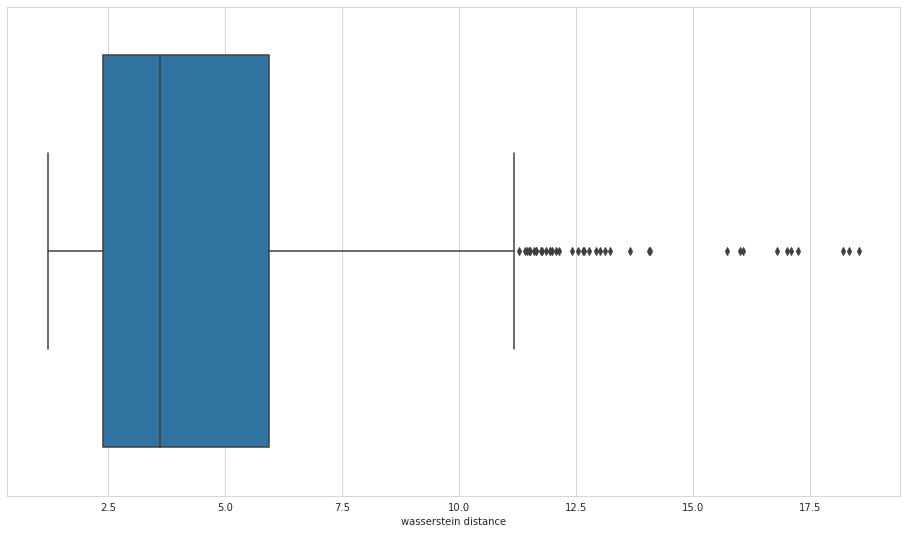

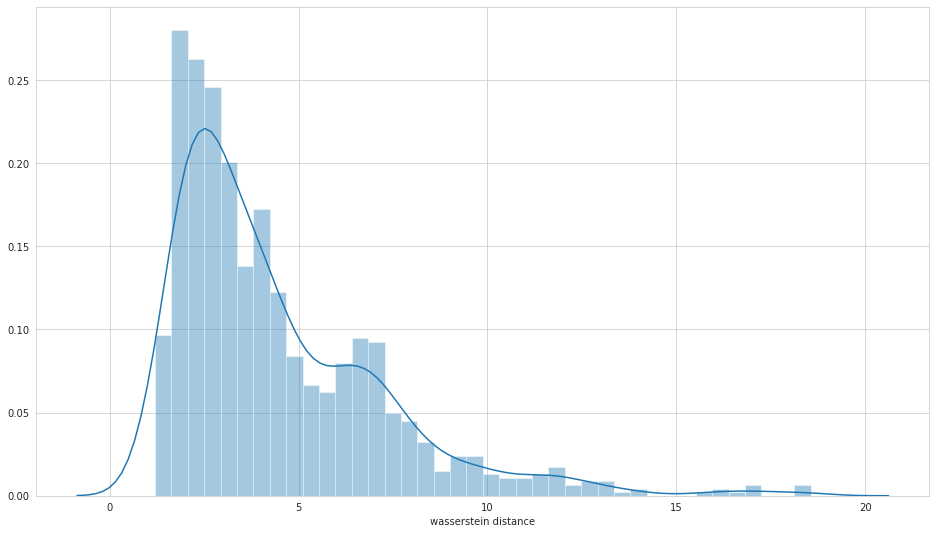

In [25]:
sns.boxplot(x="wasserstein distance", data=test_results_df)
plt.show()
sns.distplot(test_results_df["wasserstein distance"], bins=40)
plt.show()

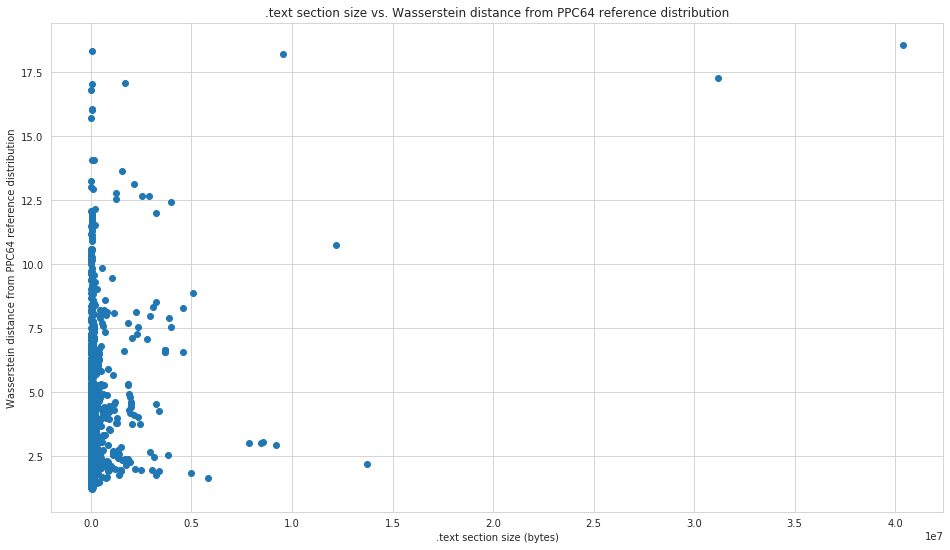

In [26]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from PPC64 reference distribution")
plt.title(".text section size vs. Wasserstein distance from PPC64 reference distribution")
plt.show()

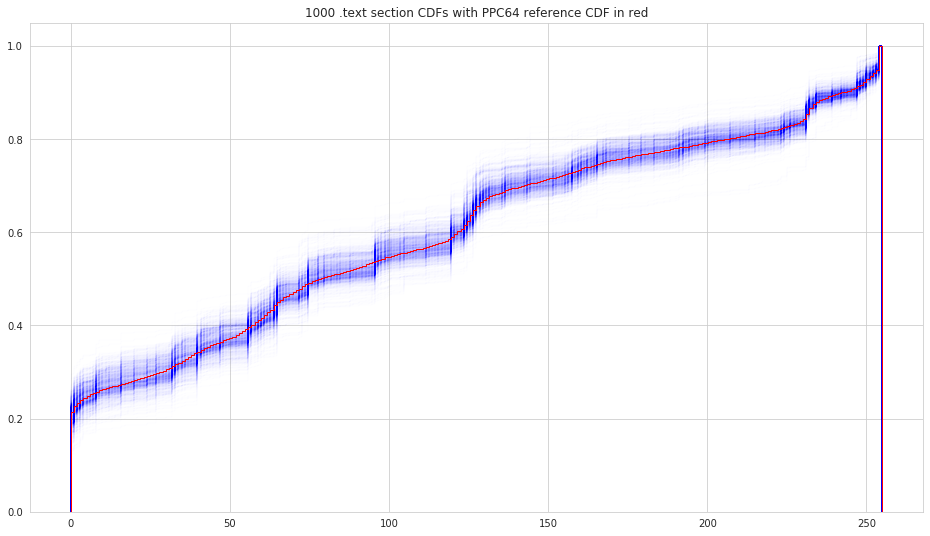

In [27]:
for code in test_code_dict.values():
    plot_sample(code)
    
sns.distplot(median, # reference distribution
             norm_hist=True,     
             kde=False,
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},
             kde_kws={'cumulative': True},
             bins=256,                      
             color="red")

plt.title("1000 .text section CDFs with PPC64 reference CDF in red")
plt.show()

In [28]:
# export reference distribution
with open("PPC64_reference", "wb") as f:
    pickle.dump(median, f)